## Neuronales Netz Basisfunktionen in Numpy

In [1]:
import numpy as np
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")
from sklearn.metrics import accuracy_score

In [2]:
# D: Architektur des neuronalen Netzwerks
# wichtig ist, dass die aufeinander folgenden Layer die gleiche Größe haben
# ---------
# E: architecture of the neural network
# it is important that the successive layers have the same size
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

In [3]:
# D: Das Netz muss am Anfang initialisiert werden 
# und das am besten nicht mit 0, weil dann kommt
# immer 0 raus
# ---------
# E: The net must be initialized at the beginning 
# and this best not with 0, because then comes
# always 0 comes out
def init_layers(nn_architecture, seed = 99):
    # D: Wahl eines Random Seed, zur Reproduzierbarkeit 
    # ---------
    # E: Choice of a random seed, for reproducibility
    np.random.seed(seed)
    # D: Anzahl der Layer
    # ---------
    # E: Number of layers
    number_of_layers = len(nn_architecture)
    # D: Speicher der Gewichte
    # ---------
    # Weights memory
    params_values = {}
    
    # D: Schleife über alle Layer
    # ---------
    # E: Loop over all layers
    for idx, layer in enumerate(nn_architecture):
        # D: Wir starten bei 1 (ausnahmweise)
        # ---------
        # E: Starting at 1 
        layer_idx = idx + 1
        
        # D: Input und output Dimensionen
        # ---------
        # E: Input and output dimensions
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # D: Initialisieren der Gewichte W und der Vektoren b
        # für jeden Layer mit normalverteilen Werten
        # ---------
        # E: Initialize the weights W and the vectors b
        # for each layer with normally distributed values
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

In [4]:
# D: Aktivierungsfunktionen und deren Ableitung
# ---------
# E: Activation functions and their derivatives
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [5]:
# D: Vorwärtsdurchlauf einen einzelnen Layers
# ---------
# E: Forward pass through a single layer
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # D: Berechnung des Inputs mit den Gewichten (w) und dem Bias (b)
    # ---------
    # E: Calculation of the input with the weights and the bias
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # D: Auswahl der Aktivierungsfunktion
    # ---------
    # E: Selection of activation function
    if activation == "relu":
        activation_func = relu
    elif activation == "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # D: Rückgabe der neuen Inputs für das nächste Layer
    # ---------
    # E: Return the new input for the next layer
    return activation_func(Z_curr), Z_curr

In [6]:
# D: Volle Berechnung des Vorwärtsdurchlauf durch das gesamte Netz
# ---------
# E: Full calculation of the forward pass through the entire network
def full_forward_propagation(X, params_values, nn_architecture):
    # D: temporärer Speicher für den Rückwärtslauf
    # ---------
    # E: temporary memory for backward run
    memory = {}
    # D: Erster Input
    # ---------
    # E: first input
    A_curr = X
    
    # D: Schleife über alle Layer
    # ---------
    # E: loop over all layer
    for idx, layer in enumerate(nn_architecture):
        # D: wir starten wiede bei 1 
        # ---------
        # E: starting at 1
        layer_idx = idx + 1
        # D: Setze den Output der letzten Iteration auf die aktuelle
        # ---------
        # E: Set the output of the last iteration to the current one
        A_prev = A_curr
        
        # D: Auswahl der Aktivierungsfunktion
        # ---------
        # E: Selection of the activation function
        activ_function_curr = layer["activation"]
        # D: Auswahl der entsprechenden Gewichte
        # ---------
        # E: Selection of the corresponding weights
        W_curr = params_values["W" + str(layer_idx)]
        # D: Auswahl der entsprechenden Biases
        # ---------
        # E: Selection of the appropriate biases
        b_curr = params_values["b" + str(layer_idx)]
        # D: Vorwärtsdurchlauf des aktuellen Layers
        # ---------
        # E: Forward pass through the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # D: Speichern alles wichtige für später
        # ---------
        # E: Save everything important for later
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # D: Rückgabe des Outputs und der gespeicherten Werte für später
    # ---------
    # E: Return the output and the stored values for later
    return A_curr, memory

In [7]:
# D: Berechung der Kostenfunktion, also wie gut ist denn unser Model 
# ---------
# E: Calculation of the cost function, so how good is our model? 
def get_cost_value(Y_hat, Y):
    # D: Anzahl der Beispiel
    # ---------
    # E: Number of examples
    m = Y_hat.shape[1]
    # D: Berechnung der Kosten anhand der logistischen Regression
    # ---------
    # E: Calculation of the costs using logistic regression
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

In [8]:
# D: Hilfsfunktion um die vorhergesagten Wahrscheinlichkeiten in die Klassen umzuwandeln
# ---------
# E: Auxiliary function to convert the predicted probabilities into the classes
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [9]:
# D: Berechnung der Genauigkeit unseres Models
# ---------
# E: Calculation of the accuracy of our model
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [10]:
# D: Rückwärtsdurchlauf durch ein einzelnes Layer, um die Parameter zu verbessern
# ---------
# E: Backward pass through a single layer to improve the parameters
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # D: Anzahl der Beispiel
    # ---------
    # E: Number of examples
    m = A_prev.shape[1]
    
    # D: Auswahl der Aktivierungsfunktion
    # ---------
    # E: Selection of the activation function
    if activation == "relu":
        backward_activation_func = relu_backward
    elif activation == "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # D: Berechnung der Ableiung der Aktivierungsfuktion
    # ---------
    # E: Calculation of the derivative of the activation function
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # D: Ableitung der Gewichtsmatrix W
    # ---------
    # E: Derivation of the weight matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # D: Ableitung des Biasvektors b
    # ---------
    # E: Derivation of bias vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # D: Ableitung der Inputmatrix A_prev
    # ---------
    # E: Derivative of the input matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    # D: Rückgabe aller Ableitungen
    # ---------
    # E: Return derivatives
    return dA_prev, dW_curr, db_curr

In [11]:
# D: Rückwärtsdurchlauf durch das gesamte Netz
# ---------
# E: Backward pass through the entire network
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # D: Anzahl der Beispiele
    # ---------
    # E: Number of examples
    m = Y.shape[1]
    # D: Sicherstellen, dass alles die gleiche Dimension hat
    # ---------
    # E: Ensure that everything has the same dimension
    Y = Y.reshape(Y_hat.shape)
    
    # D: Erster Schritt des Gradientenabstiegs
    # ---------
    # E: First step of the gradient descent
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # D: Wir starten immernoch bei 1
        # ---------
        # E: Starting at 1
        layer_idx_curr = layer_idx_prev + 1
        # D: Auswahl der aktuellen Aktivierungsfunktion
        # ---------
        # E: Selection of the current activation function
        activ_function_curr = layer["activation"]

        # D: Initialisung der entsprechenden Werte
        # ---------
        # E: Initialization of the corresponding values
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]

        # D: Rückwärtsdurchlauf durch das aktuelle Layer
        # ---------
        # E: Backwards through the current layer
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        # D: Speichern der entsprchenden Gradienten
        # ---------
        # E: Save the corresponding gradient
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

In [12]:
# D: Funktion um die Gewichte der Layer zu verändern
# ---------
# E: Function to change the weights of the layers
def update(params_values, grads_values, nn_architecture, learning_rate):

    # D: Schleife über alle Layer
    # ---------
    # E: Loop over all layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        # D: Update aller Gewichte
        # ---------
        # E: Update the weights
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values

In [13]:
# D: Funktion die alles was wir vorher gebaut haben zusammenführt
# ---------
# E: Function that merges everything we have built before
def train(X, Y, X_test, Y_test,nn_architecture, epochs, learning_rate, verbose=False):
    # D: Initialisierung des Netzes
    # ---------
    # E: Initialization of the network
    params_values = init_layers(nn_architecture, 2)
    # D: Initialisierung, um das Training später anzuschauen
    # ---------
    # E: Initialization to view the training later on
    cost_history = []
    accuracy_history = []
    cost_test_history = []
    accuracy_test_history = [] 
    
    # D: Schleife über eine vorher festgelegte Anzahl an Durchlöufen
    # ---------
    # E: Loop over a predefined number of passes
    for i in range(epochs):
        # D: kompletter Vorwärtsschritt
        # ---------
        # E: complete forward step
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        
        # D: Berechnung von Kosten und Genauigkeit und speichern
        # ---------
        # E: Calculation of costs and accuracy and save
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)

        Y_hat_test, _ = full_forward_propagation(X_test, params_values, nn_architecture)
        cost_test = get_cost_value(Y_hat_test, Y_test)
        cost_test_history.append(cost_test)
        accuracy_test = get_accuracy_value(Y_hat_test, Y_test)
        accuracy_test_history.append(accuracy_test)
        
        # D: kompletter Rückwärtsschritt um den Gradienten (Ableitung) zu berechnen
        # ---------
        # E: complete backward step to calculate the gradient (derivative)
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # D: Update der Parameter im Netz
        # ---------
        # E: Update the parameters in the network
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)

        # D: Ausdrucken der aktuellen Werte des Trainings
        # ---------
        # E: Printout of the current values of the training
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            
    return params_values, [cost_history, accuracy_history, cost_test_history, accuracy_test_history]

## Visualisierung der Daten

In [14]:
# D: Größe des Datensatzes
# ---------
# E: Size of the dataset
N_SAMPLES = 1000
# D: Größe des Testsets
# ---------
# E: Size of the testset
TEST_SIZE = 0.1

In [15]:
# D: Generierung des Datansatzes und split in test und train set
# ---------
# E: generation of the data set and split into test and train set
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [16]:
# D: Hilfsfunktion um die Daten zu Visualisiern
# ---------
# E: Help function to visualize the data
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

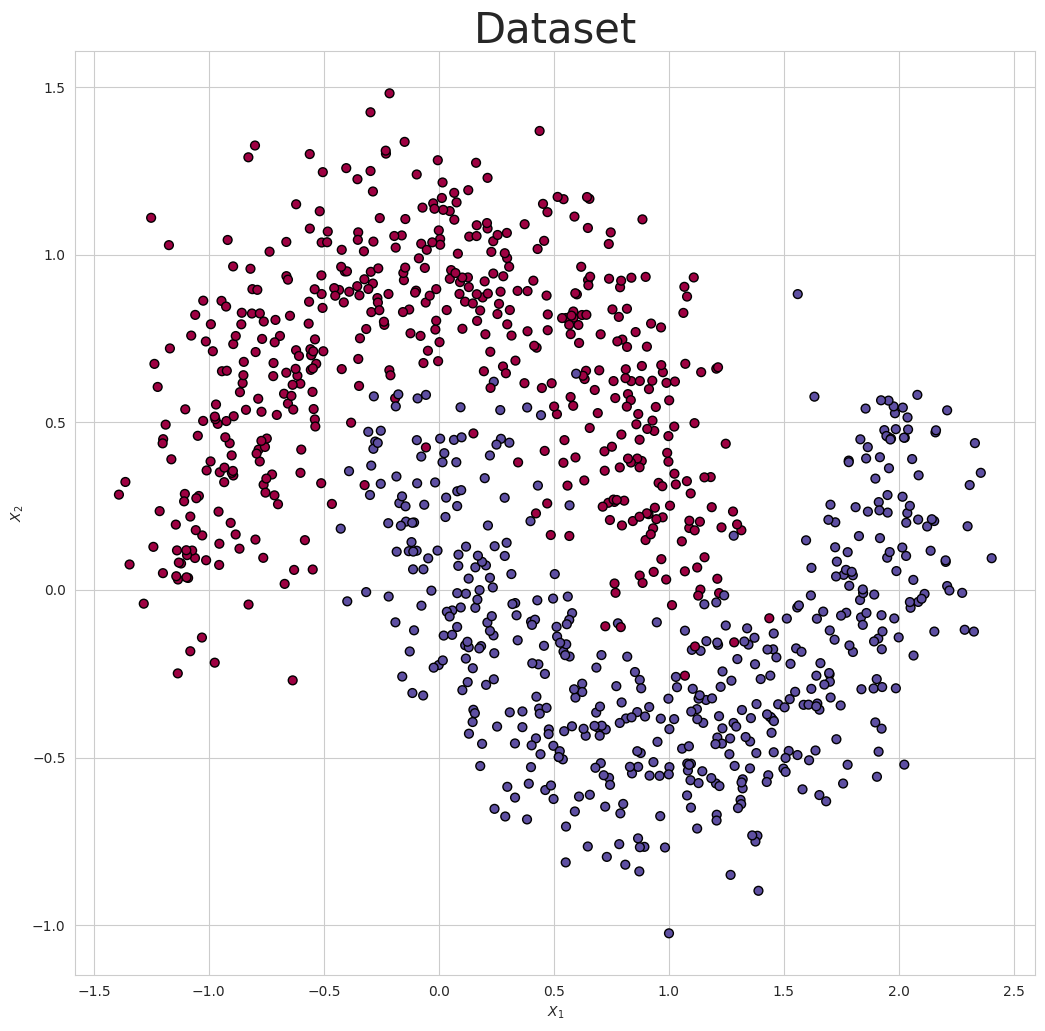

In [17]:
# D: Visualisiung des gesamten Datensatzes
# ---------
# E: Visualization of the entire data set
make_plot(X, y, "Dataset")

## Training des Models und Visualisung der Ergebnisse

In [18]:
# D: Training des Neuronalen Netzes
# 10000 Gradientenschritte
# Lernrate 0.01
# ---------
# E: Training of the neural network
# 10000 gradient steps
# learning rate 0.01
params_values, history = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))),np.transpose(X_test), np.transpose(y_test.reshape((y_test.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01)

In [19]:
# D: Vorwärtsdurchlauf auf den Testdaten mit den gelernten Gewichten
# ---------
# E: Forward pass on the test data with the weights learned
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [20]:
# D: Check der Genauigkeit
# ---------
# E: check accuracy
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 0.98


In [21]:
# D: Hilfsfunktion Kosten und Genauigkeit zu visualisieren
# ---------
# E: Help function to visualize cost and accuracy
def plot_learn_data(data1,data2,name="Cost"):
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$Epochen$", ylabel=name)
    plt.title(name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    plt.plot(data1)
    plt.plot(data2)
    axes.legend(['Train Set', 'Test Set'])

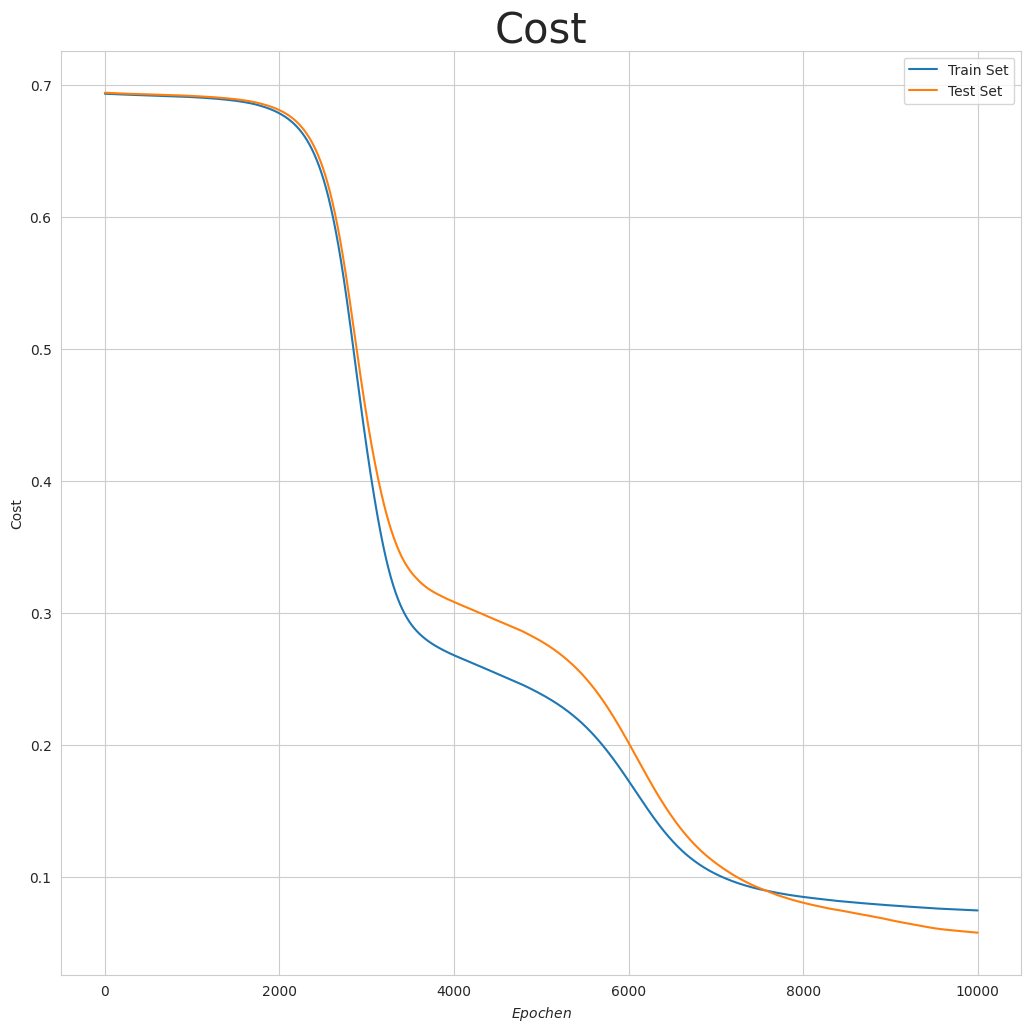

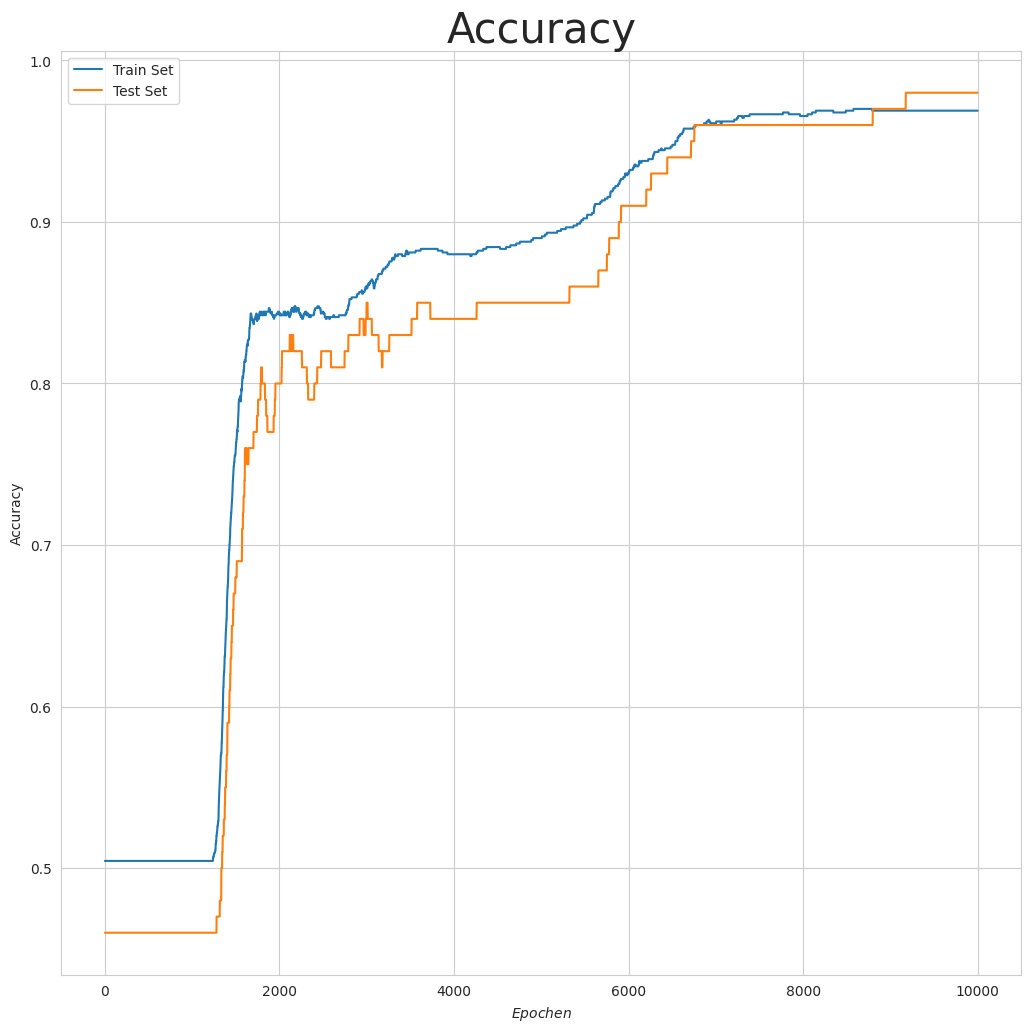

In [22]:
# D: Plot der Kostenfunktion
# ---------
# E: Plot of the cost function
plot_learn_data(history[0],history[2])
# D: Plot Genauigkeit
# ---------
# E: Plot of the accuracy
plot_learn_data(history[1],history[3],name="Accuracy")

In [23]:
# D: Hilfsvariablen für die Visualisierung
# ---------
# E: Auxiliary variables for visualization
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2

# D: Erstellen eines Gitter für das Bild
# ---------
# E: Create a grid for the image
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

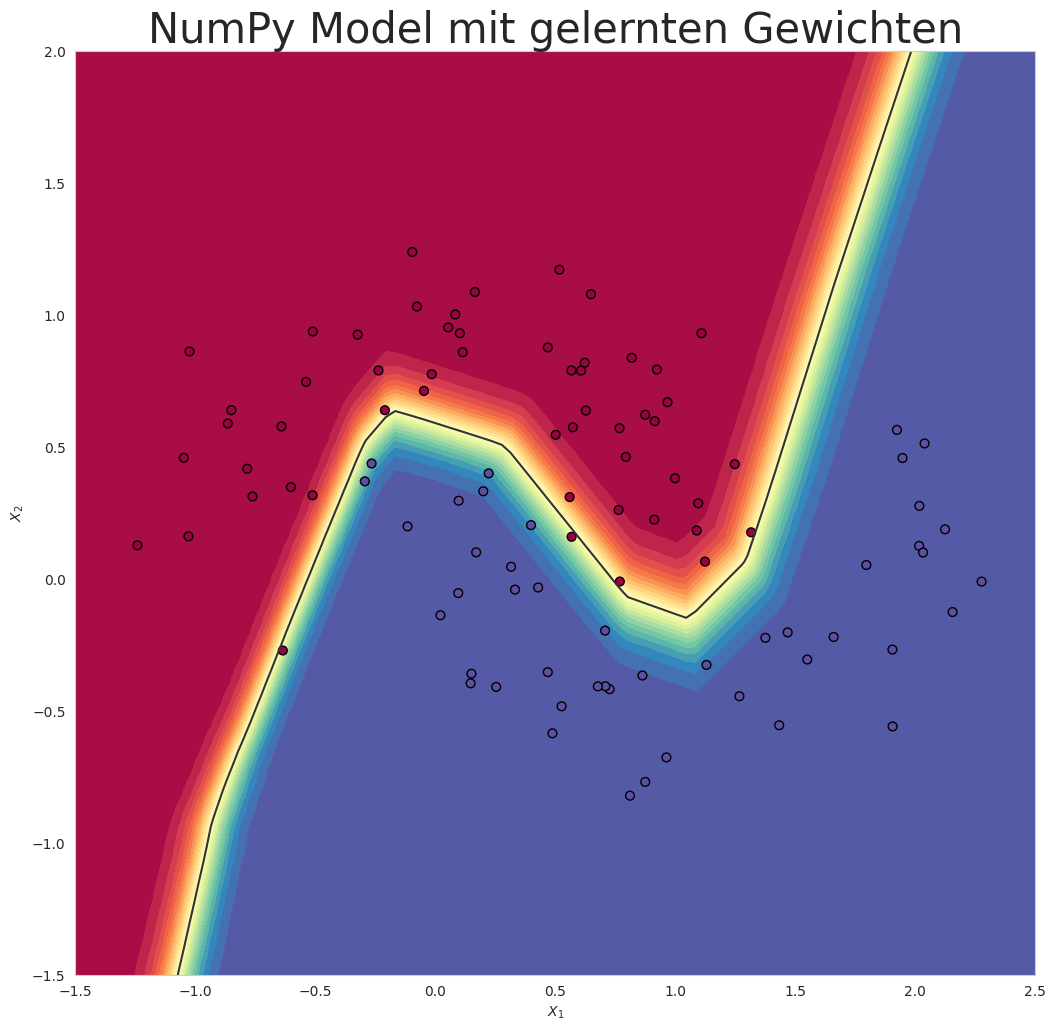

In [24]:
# D: Vorwärtsdurchlauf des Netzes mit dem gelernten Gewichten auf dem Gitter
# ---------
# E: Forward pass of the mesh with the learned weights on the grid.
prediction_probs_numpy, _ = full_forward_propagation(np.transpose(grid_2d), params_values, NN_ARCHITECTURE)
prediction_probs_numpy = prediction_probs_numpy.reshape(prediction_probs_numpy.shape[1], 1)
# D: Visualisierung der gelernten Gewichte und dem Test set
# ---------
# E: Visualization of the learned weights and the test set
make_plot(X_test, y_test, "NumPy Model mit gelernten Gewichten", file_name=None, XX=XX, YY=YY, preds=prediction_probs_numpy)

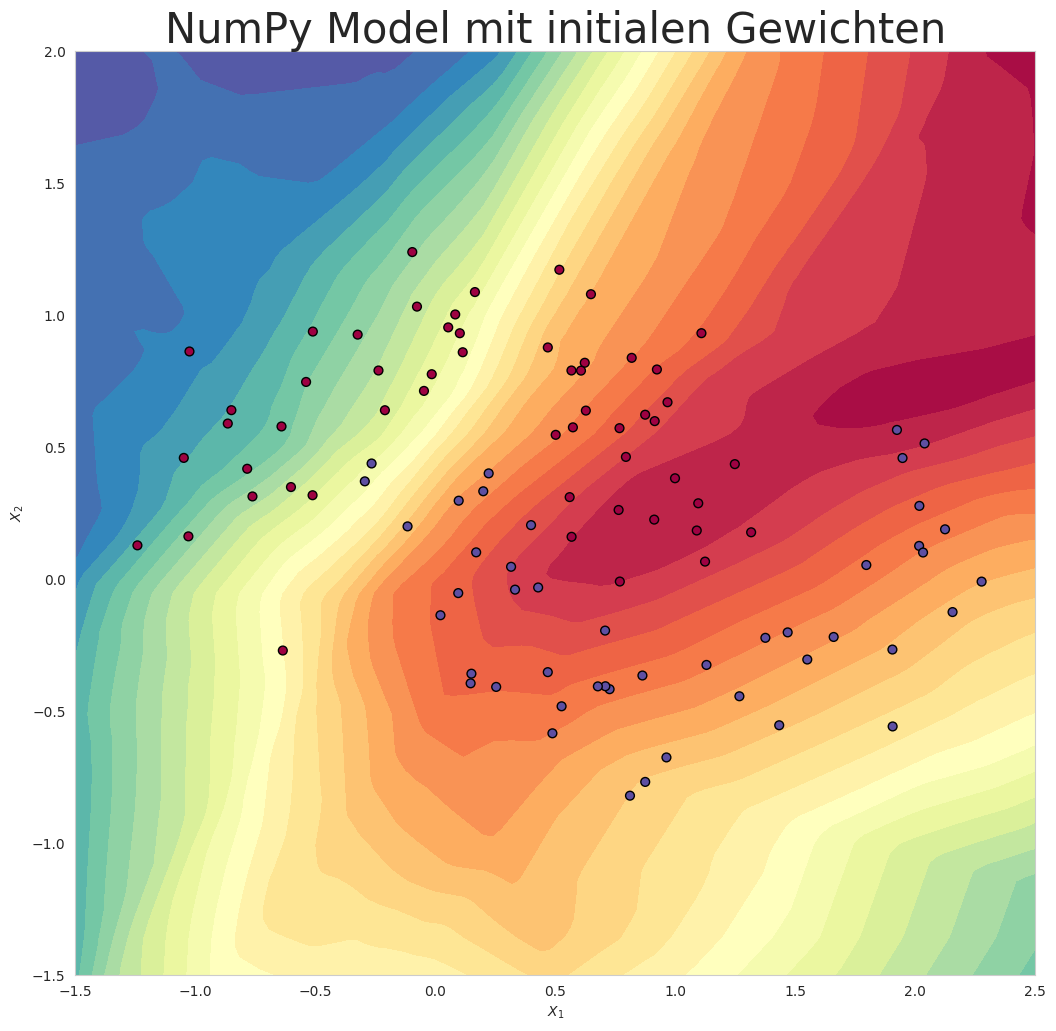

In [25]:
# D: Initialisierung eines neuen Netzwerks mit der gleichen Architektur
# ---------
# E: Initialization of a new network with the same architecture
init_values = init_layers(NN_ARCHITECTURE, 2)
prediction_probs_numpy, _ = full_forward_propagation(np.transpose(grid_2d), init_values, NN_ARCHITECTURE)
prediction_probs_numpy = prediction_probs_numpy.reshape(prediction_probs_numpy.shape[1], 1)
# D: Visualisierung der initialen Gewichte und dem Test set
# ---------
# E: Visualization of the initial weights and the test set
make_plot(X_test, y_test, "NumPy Model mit initialen Gewichten", file_name=None, XX=XX, YY=YY, preds=prediction_probs_numpy)